# Imports

In [1]:
import json
import random
import os

import cv2
import cyvlfeat
from matplotlib import pyplot as plt
import numpy as np
from pprint import pprint
from skimage.draw import line_nd
import torch
import torchvision

from ipywidgets import *
from IPython.display import display

device = "cpu"

%matplotlib inline

# Function Definitions

## Helper Functions 

In [2]:
def save_config(filename, func_stack, config_stack):
    if not filename.endswith(".json"):
        filename += ".json"
        
    exp = {
        "func_stack": func_stack,
        "config_stack": config_stack,
    }
    
    with open(filename, "w") as file:
        json.dump(exp, file, indent=4)
        
    print(filename, "is created.")
    
def load_config(json_content, func_stack, config_stack):
    print("Previous functions:")
    pprint(func_stack)
    print("Previous configurations:")
    pprint(config_stack)
    
    exp = json.loads(json_content)
    func_stack[:] = exp["func_stack"]
    config_stack[:] = exp["config_stack"]
    
    print("Current functions:")
    pprint(func_stack)
    print("Current configurations:")
    pprint(config_stack)

def update_log(log, stack):
    with log:
        log.clear_output()
        for i, func in enumerate(stack):
            print("{}: {}".format(i, func))

def push(stack, log, e):
    stack.append(e.description)
    update_log(log, stack)

def pop(stack, log):
    if len(stack) > 0:
        stack.pop()
    update_log(log, stack)
                
def compute_line_pixels(shape, rho, theta):
    # Compute intercepts for upper and lower edges, compute pixels of the line passing through them
    upper = 0
    lower = shape[0] - 1
    p1 = (upper, rho/np.cos(theta))
    p2 = (lower, (rho-lower*np.sin(theta))/np.cos(theta))
    pixels = line_nd(p1, p2, endpoint=True)
    
    # Convert NumPy indices to OpenCV coordinates for proper drawing
    cv_y, cv_x = pixels
    coords = np.stack((cv_x.reshape(-1, 1), cv_y.reshape(-1, 1)), axis=2)
    
    # Take 1st quadrant coordinates only
    coords = coords[coords.min(axis=2)>=0]
    return coords

def convert_coord2mask(shape, indices):
    # Convert OpenCV coordinates to NumPy indices for proper array handling
    col, row = np.hsplit(indices, 2)
    mask = np.zeros(shape[:2], dtype=np.uint8)
    mask[row, col] = 255
    return mask

def apply_functions(image, func_stack, config_stack):
    show_image(image)
    for i in range(len(func_stack)):
        key = func_stack[i]
        image = funcs[key](image, **config_stack[i])
    return image
    
def show_image(image, h=10, w=10, cmap=None):
    plt.figure(figsize=(w,h))
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def show_contours(image, contours, contourIdx='all', cmap=None):
    # To draw all the contours in the image, set contourIdx to -1
    if contourIdx == 'all':
        contourIdx = -1

    image = cv2.drawContours(image, contours, contourIdx=contourIdx, color=(255,0,0), thickness=1)
    show_image(image, cmap=cmap)
    
def show_lines(image, params, cmap=None):
    for p in params:
        rho, theta = p.ravel()
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(image, (x1,y1), (x2,y2), color=(255,0,0), thickness=1)
    
    show_image(image, cmap=cmap)

def show_image_pairs(left, right, h=15, w=15):
    f, ax = plt.subplots(1,2)
    f.set_figheight(h)
    f.set_figwidth(w)
    ax[0].imshow(left)
    ax[1].imshow(right)
    plt.show()

## UI Callback Functions

Register a callback for configuration of image processing methods here if needed.

In [3]:
def threshold_config(thresh, maxval, type):
    return {"thresh": thresh, "maxval": maxval, "type": type}

def adaptive_threshold_config(maxValue, adaptiveMethod, thresholdType, blockSize, C):
    return {"maxValue": maxValue, "adaptiveMethod": adaptiveMethod, "thresholdType": thresholdType, "blockSize": blockSize, "C": C}

def avg_blur_config(ksize):
    return {"ksize": ksize}

def median_blur_config(ksize):
    return {"ksize": ksize}

def bilateral_filter_config(d, sigmaColor, sigmaSpace):
    return {"d": d, "sigmaColor": sigmaColor, "sigmaSpace": sigmaSpace}

def gaussian_blur_config(ksize, sigmaX):
    return {"ksize": (ksize, ksize), "sigmaX": sigmaX}

def laplacian_config(ksize):
    return {"ksize": ksize}
    
def sobelv_config(ksize):
    return {"ksize": ksize}
    
def sobelh_config(ksize):
    return {"ksize": ksize}

def canny_config(threshold1, threshold2):
    return {"threshold1": threshold1, "threshold2": threshold2}

def hough_line_config(threshold):
    return {"threshold": threshold}

## Image Processing Functions

Register image processing functions to be used here.

In [4]:
def convert_grayscale(image, visualize=True, **kwargs): # **kwargs is ignored
    """Takes an RGB (3 channel) image, returns the grayscale image (1 channel)"""
    print("Converting to grayscale")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if visualize:
        show_image(image, cmap="gray")
    return image

def enhance_contrast(image, **kwargs): # **kwargs is ignored
    print("Enhancing contrast")
    return cv2.equalizeHist(image)

def apply_threshold(gray_img, visualize=True, **kwargs):
    """Takes grayscale image, returns thresholded version."""
    print("Applying standard threshold with args:", kwargs)
    _retval, gray_img = cv2.threshold(gray_img, **kwargs)
    if visualize:
        show_image(gray_img, cmap="gray")
    return gray_img

def apply_adaptive_threshold(gray_img, **kwargs):
    """Takes grayscale image, returns thresholded version."""
    print("Applying adaptive threshold with args:", kwargs)
    return cv2.adaptiveThreshold(gray_img, **kwargs)

def apply_filter(image, kernel):
    return cv2.filter2D(image, ddepth=-1, kernel=kernel)

def apply_avg_blur(image, **kwargs):
    print("Applying average blur with args:", kwargs)
    return cv2.blur(image, **kwargs)

def apply_median_blur(image, **kwargs):
    print("Applying median blur with args:", kwargs)
    return cv2.medianBlur(image, **kwargs)

def apply_bilateral_filter(image, **kwargs):
    print("Applying bilateral filter with args:", kwargs)
    return cv2.bilateralFilter(image, **kwargs)

def apply_gaussian_blur(image, visualize=True, **kwargs):
    print("Applying Gaussian blur with args:", kwargs)
    image = cv2.GaussianBlur(image, **kwargs)
    if visualize:
        show_image(image)
    return image

def apply_laplacian(image, visualize=True, **kwargs): # TODO:
    print("Applying Laplacian filter for vertical and horizontal edges with args:", kwargs)
    image = cv2.Laplacian(image, cv2.CV_64F, **kwargs) # Detect both + & - edges
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_sobelv(image, visualize=True, **kwargs): # TODO:
    print("Applying Sobel filter for vertical edges (along y-axis) with args:", kwargs)
    image = cv2.Sobel(image, cv2.CV_64F, dx=1, dy=0, **kwargs) # Detect both + & - edges
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_sobelh(image, visualize=True, **kwargs): # TODO:
    print("Applying Sobel filter for horizontal edges (along x-axis) with args:", kwargs)
    image = cv2.Sobel(image, cv2.CV_64F, dx=0, dy=1, **kwargs) # Detect both + & - edges
    image = np.absolute(image) # Take absolute value to make it unsigned
    image = np.uint8(image)    # Convert dtype back to uint8
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_canny(image, visualize=True, **kwargs):
    """Takes an RGB or grayscale image, returns the binary mask for edge locations"""
    print("Applying canny with args:", kwargs)
    image = cv2.Canny(image, **kwargs)
    if visualize:
        show_image(image, cmap="gray")
    return image

def apply_contour(bin_image, visualize=True, **kwargs):
    """
    Takes binary image (obtained with Canny or thresholding) to find contours (which separate white region from black background).
    'contours' is a list of all the contours in the image. 
    Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    Returns 'contours'.
    """
    print("Applying contours with args:", kwargs)
    _bin_image, contours, _hierarchy = cv2.findContours(bin_image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
    if visualize:
        show_contours(np.zeros_like(image), contours, contourIdx=-1, cmap="gray")
    
    return contours

def apply_hough_line(bin_image, visualize=True, **kwargs):
    """
    Takes binary image (obtained with Canny or thresholding) to find parameters of lines that exist in the image.
    'line_params' is a list of parameters for each line in the image. 
    Each individual line parameter is a Numpy array of (rho, theta) parameters of the line.
    Returns pixel coordinates for all points of each line.
    """
    print("Applying Hough line with args:", kwargs)
    line_params = cv2.HoughLines(bin_image, rho=1, theta=np.pi/180, **kwargs)
    
    # Construct each line and store respective mask
    line_pixels = []
    for p in line_params:
        rho, theta = p.ravel()
        pixels = compute_line_pixels(bin_image.shape, rho, theta)
        line_pixels.append(pixels)
        
    if visualize:
        show_contours(np.zeros_like(bin_image), line_pixels, contourIdx=-1, cmap="gray")

    return line_pixels

# Load Frames

In [5]:
# indices = list(range(1, 16))
# choice = str(random.choice(indices))
# print("Choice:", choice)
choice = str(13)

rgb_img_ext = choice + "_rgb.png"
depth_img_ext = choice + "_depth.png"
depth_arr_ext = choice + "_depth.npy"

folders = os.listdir("frames")
folders = list(map(lambda folder: os.path.join("frames", folder), folders))
triplets = []
for folder in folders:
    rgb_im_path = os.path.join(folder, rgb_img_ext)
    depth_im_path = os.path.join(folder, depth_img_ext)
    depth_arr_path = os.path.join(folder, depth_arr_ext)
    
    rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)     # BGR image
    depth_img = cv2.imread(depth_im_path, cv2.IMREAD_COLOR) # BGR image
    depth_arr = None # np.load(depth_arr_path, allow_pickle=True) # TODO: Save frames with allow_pickle=False
    triplets.append((rgb_img, depth_img, depth_arr))
    
print("Number of triplets:", len(triplets))

Number of triplets: 8


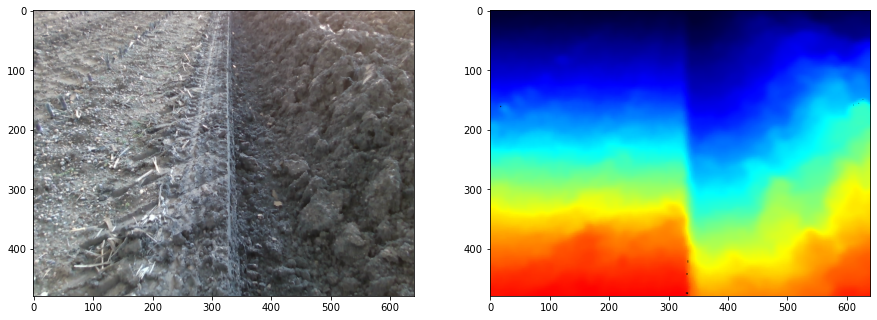

In [6]:
# indices = list(range(8))
# choice = str(random.choice(indices))
# print("Choice:", choice)
choice = 4

rgb_img, depth_img, depth_arr = triplets[choice]

show_image_pairs(rgb_img, depth_img)

# Define Name-Method and Name-UI Mappings

Bind names to the methods and UI elements. Define new names and UI elements here if needed.

In [7]:
# Binding names to actual methods:
preproc_funcs = {
    "Grayscale": convert_grayscale,
    "Contrast": enhance_contrast,
    "Threshold": apply_threshold,
    "Adaptive Threshold": apply_adaptive_threshold,
    "Average Blur": apply_avg_blur,
    "Median Blur": apply_median_blur,
    "Bilateral Filter": apply_bilateral_filter,
    "Gaussian Blur": apply_gaussian_blur,  
    "Laplacian": apply_laplacian,
    "Sobel Vertical": apply_sobelv,
    "Sobel Horizontal": apply_sobelh,
}

detect_funcs = {
    "Canny Edges": apply_canny,
    "Contour": apply_contour,
    "Hough Line": apply_hough_line,
}

funcs = {**preproc_funcs, **detect_funcs}

# Defining UI elements for configurations
threshold_ui = lambda: interactive(threshold_config, thresh=(0,255), maxval=(0,255), 
                           type={"Binary": cv2.THRESH_BINARY,
                                 "Binary Inverted": cv2.THRESH_BINARY_INV,
                                 "Trunctate": cv2.THRESH_TRUNC,
                                 "To Zero": cv2.THRESH_TOZERO,
                                 "To Zero Inverted": cv2.THRESH_TOZERO_INV})
adaptive_threshold_ui = lambda: interactive(adaptive_threshold_config, 
                                       maxValue=(0,255), 
                                       adaptiveMethod={
                                           'Adaptive Gaussian Thresholding': cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           'Adaptive Mean Thresholding': cv2.ADAPTIVE_THRESH_MEAN_C},
                                       thresholdType={"Binary": cv2.THRESH_BINARY,
                                                      "Binary Inverted": cv2.THRESH_BINARY_INV,
                                                      "Trunctate": cv2.THRESH_TRUNC,
                                                      "To Zero": cv2.THRESH_TOZERO,
                                                      "To Zero Inverted": cv2.THRESH_TOZERO_INV},
                                       blockSize=(0,20),
                                       C=(0,20))
avg_blur_ui = lambda: interactive(avg_blur_config, ksize=(1,20))
median_blur_ui = lambda: interactive(median_blur_config, ksize=(1,20))
bilateral_filter_ui = lambda: interactive(bilateral_filter_config, d=(1,20), sigmaColor=(1,100), sigmaSpace=(1,100))
gaussian_blur_ui = lambda: interactive(gaussian_blur_config, ksize=(1,20), sigmaX=(1,20))
laplacian_ui = lambda: interactive(laplacian_config, ksize=(1,20))
sobelv_ui = lambda: interactive(sobelv_config, ksize=(1,20))
sobelh_ui = lambda: interactive(sobelh_config, ksize=(1,20))
canny_ui = lambda: interactive(canny_config, threshold1=(0,100), threshold2=(0,100))
hough_line_ui = lambda: interactive(hough_line_config, threshold=(0,1000))

# Binding names to the configuration UI elements
preproc_ui = {
    "Grayscale": None,
    "Contrast": None,
    "Threshold": threshold_ui,
    "Adaptive Threshold": adaptive_threshold_ui,
    "Average Blur": avg_blur_ui,
    "Median Blur": median_blur_ui,
    "Bilateral Filter": bilateral_filter_ui,
    "Gaussian Blur": gaussian_blur_ui,
    "Laplacian": laplacian_ui,
    "Sobel Vertical": sobelv_ui,
    "Sobel Horizontal": sobelh_ui,
}

detect_ui = {
    "Canny Edges": canny_ui,
    "Contour": None,
    "Hough Line": hough_line_ui,
}

ui_elements = {**preproc_ui, **detect_ui}

# Create New Experiment

## Select Methods 

In [8]:
style = {
    'description_width': 'initial'
}

func_stack = []
add_buttons = []
log = Output(layout={'margin': '0px 50px 0px 50px', 'width': "200px"})

for item in ui_elements:
    button = Button(
        description=item,
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    )
    button.on_click(lambda e: push(func_stack, log, e))
    add_buttons.append(button)

pop_button = Button(
    description="Pop",
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
)
pop_button.on_click(lambda _: pop(func_stack, log))
    
menu1 = HBox([VBox(add_buttons), log, pop_button])

display(menu1)

## Configure Selected Methods

In [9]:
ui_instances = []
for i, k in enumerate(func_stack):
    if ui_elements[k]:
        print("{} {}:".format(i, k))
        ui_instance = ui_elements[k]()
        display(ui_instance)
        ui_instances.append(ui_instance)
    else:
        ui_instances.append(None)

1 Gaussian Blur:


interactive(children=(IntSlider(value=10, description='ksize', max=20, min=1), IntSlider(value=10, description…

2 Threshold:


interactive(children=(IntSlider(value=127, description='thresh', max=255), IntSlider(value=127, description='m…

3 Canny Edges:


interactive(children=(IntSlider(value=50, description='threshold1'), IntSlider(value=50, description='threshol…

In [10]:
# Update internal state
config_stack = []
for ui_instance in ui_instances:
    config = {}
    if ui_instance:
        config = ui_instance.result
    config_stack.append(config)

## Apply Configured Methods

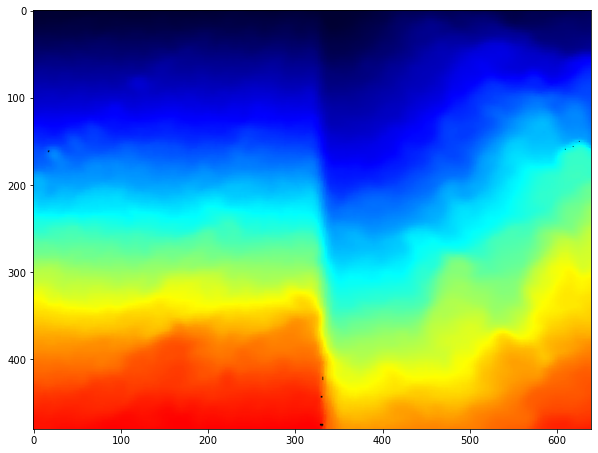

Converting to grayscale


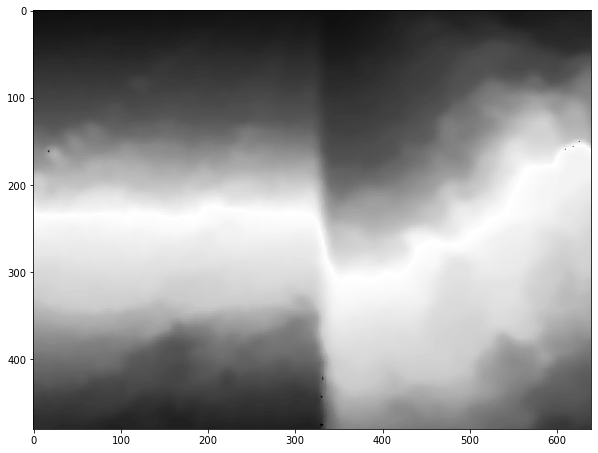

Applying Gaussian blur with args: {'ksize': (5, 5), 'sigmaX': 10}


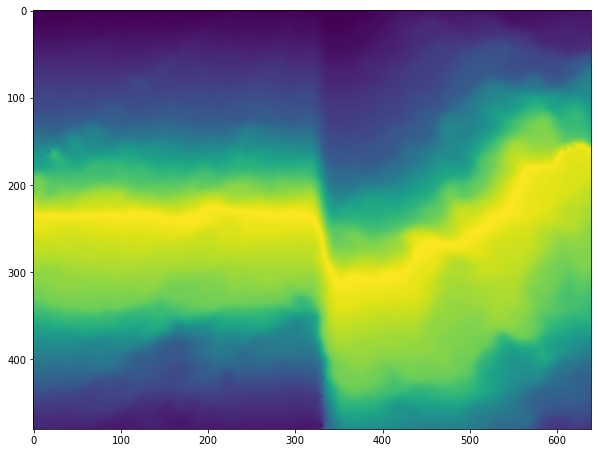

Applying standard threshold with args: {'thresh': 127, 'maxval': 255, 'type': 0}


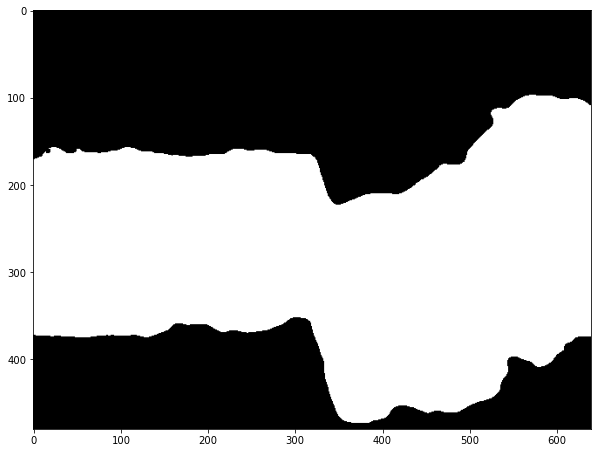

Applying canny with args: {'threshold1': 50, 'threshold2': 100}


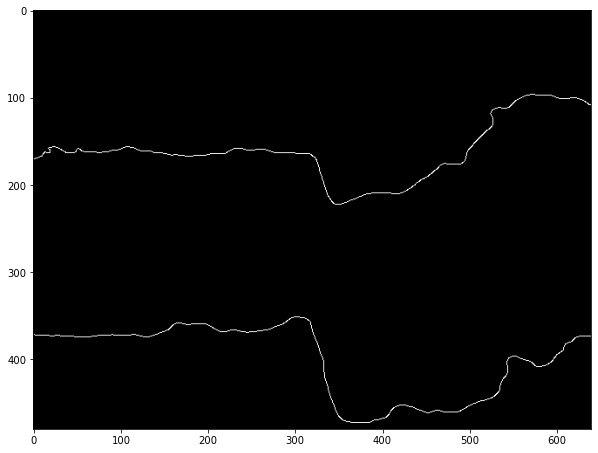

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
input_image = depth_img # rgb_img
output_image = apply_functions(input_image.copy(), func_stack, config_stack)

## Store Current Experiment

In [ ]:
text = Text(
    value='exp.json',
    placeholder='Enter a filename',
    description='Filename:',
    disabled=False
)


button = Button(
    description='Store',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

mini_form = HBox([text, button])

button.on_click(lambda _: save_config(text.value, func_stack, config_stack))

display(mini_form)

# Load Previous Experiment from File

In [ ]:
# TODO: Ability to continue with loaded experiment
uploader_ui = FileUpload(
    accept='.json', # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_config(*uploader_ui.data, func_stack, config_stack), names='_counter')

display(uploader_ui)

In [14]:
exps = []

def load_exp(json_contents, exps):
    for json_content in json_contents:
        exp = json.loads(json_content)
        exps.append((exp["func_stack"], exp["config_stack"]))
    

uploader_ui = FileUpload(
    accept='.json', # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)

uploader_ui.observe(lambda _: load_exp(uploader_ui.data, exps), names='_counter')

display(uploader_ui)

FileUpload(value={}, accept='.json', description='Upload', multiple=True)

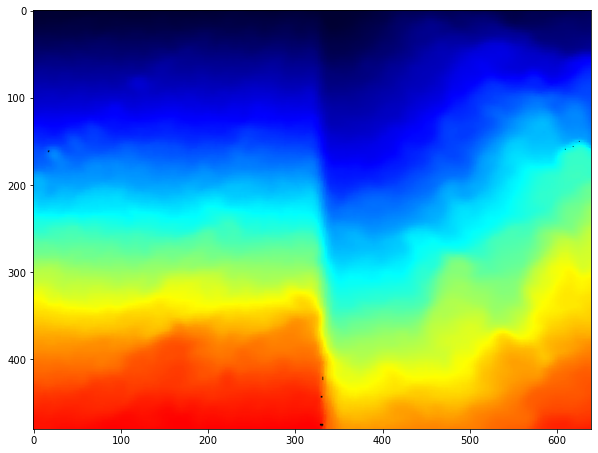

Converting to grayscale


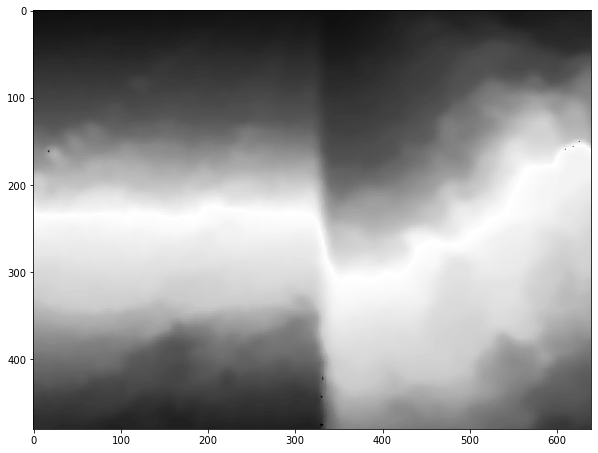

Applying standard threshold with args: {'thresh': 175, 'maxval': 255, 'type': 0}


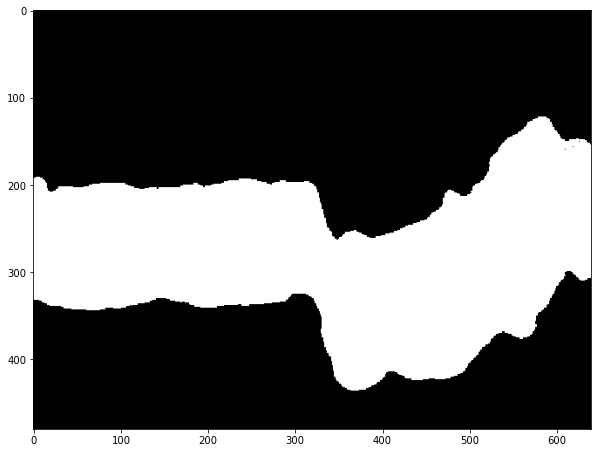

Applying canny with args: {'threshold1': 50, 'threshold2': 100}


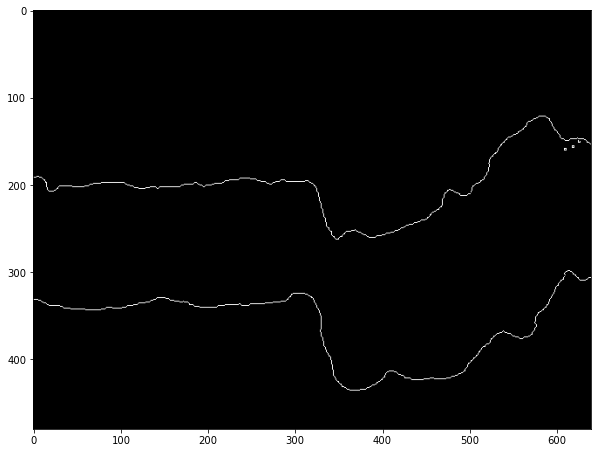

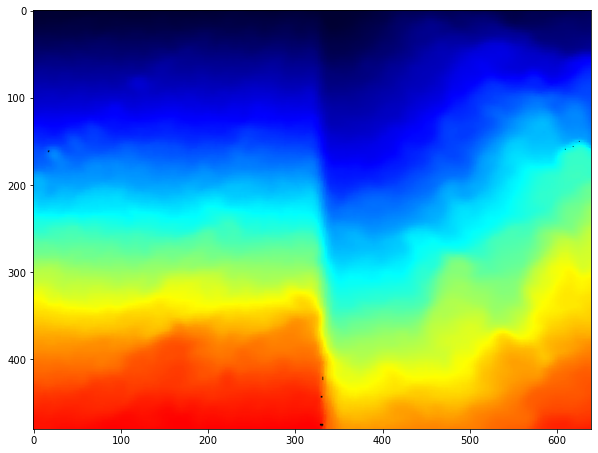

Converting to grayscale


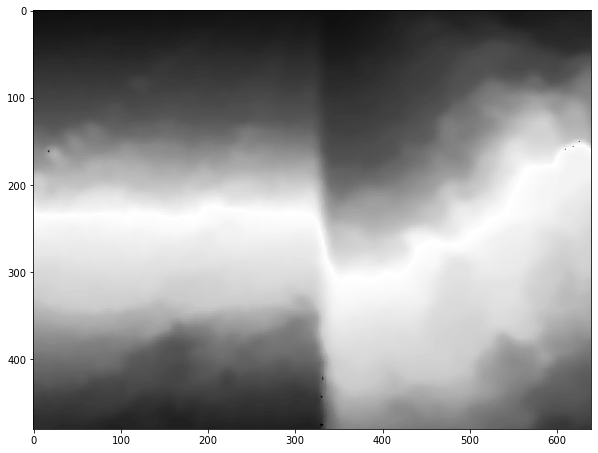

Applying Sobel filter for vertical edges (along y-axis) with args: {'ksize': 5}


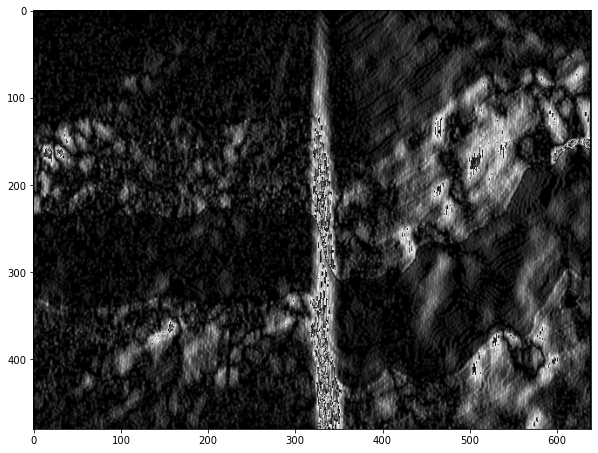

Applying standard threshold with args: {'thresh': 163, 'maxval': 255, 'type': 0}


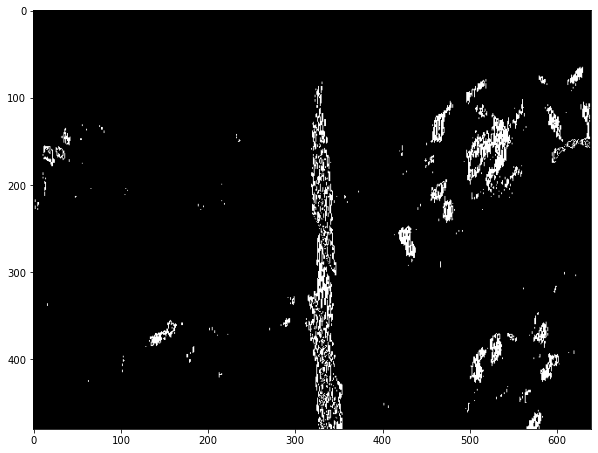

Applying Hough line with args: {'threshold': 195}


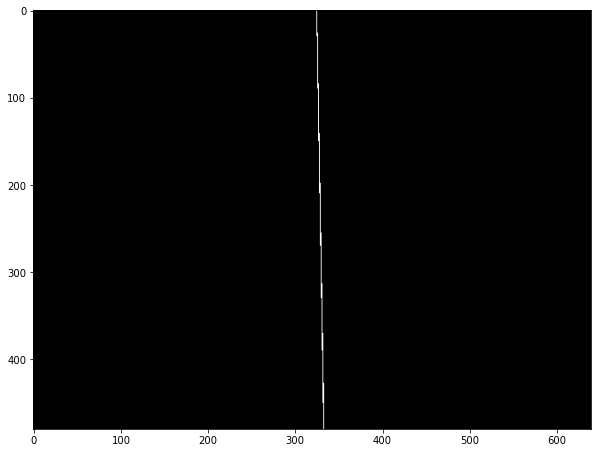

In [16]:
input_image = depth_img # rgb_img
results = []

for exp in exps:
    result = apply_functions(input_image, *exp)
    results.append(result)

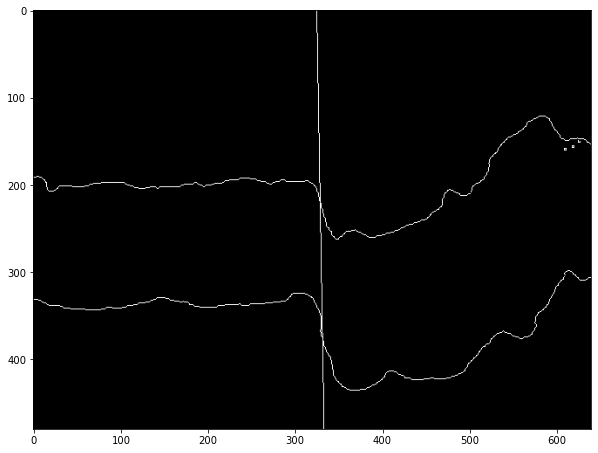

In [19]:
# Merging Canny detector result with Hough line detector result
horizontal = results[0]
vertical = convert_coord2mask(horizontal.shape, results[1][0])
merged = horizontal | vertical
show_image(merged, cmap="gray")

# Aside: Experimental

In [ ]:
orig = depth_img
modified = orig.copy()
contours = apply_contour(modified) # List of N contour arrays of shape (C, 1, 2) to represent C-many 2D points
print(len(contours))
print(contours[0].shape)
print(contours[68].shape)
show_image(orig)
show_contours(modified, contours, contourIdx=-1)

In [ ]:
orig = depth_img
modified = orig.copy()
show_image(orig)
line_pixels = apply_hough_line(modified)
# show_contours(modified, line_pixels, contourIdx=50)

In [ ]:
orig = depth_img
gray = convert_grayscale(orig)
edges1 = apply_laplacian(orig)
edges2 = apply_sobelx(orig)
edges3 = apply_sobely(orig)
show_image(gray, cmap="gray")
show_image(edges1, cmap="gray")
show_image(edges2, cmap="gray")
show_image(edges3, cmap="gray")

 # Help

## Coordinate Conventions of NumPy and OpenCV

Let us consider an arbitrary point P in the OpenCV coordinate system whose coordinates are (x, y). The same point in the NumPy image coordinate system is given by the coordinates (c, r).

Assume that we need to manipulate the image at point P and that the image is stored in the NumPy array img. OpenCV functions typically expect us to provide the coordinate information in the order **(x, y)** for its image manipulation functions. However, to access the element at point P using NumPy, we need to do **img[r, c]**.

### OpenCV Coordinates
---
![1st](notebook_images/opencv.png "OpenCV Coordinates")

### NumPy Coordinates
---
![2nd](notebook_images/numpy.png "NumPy Coordinates")

## cv2.COLOR_XXX

[cv2.COLOR_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ColorConversionCodes.html)

## cv2.THRESH_XXX

[Thresholding](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)

[cv2.THRESH_XXX](https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_ThresholdTypes.html)

## cv2.cvtColor

In [ ]:
help(cv2.cvtColor)

## cv2.equalizeHist

In [ ]:
help(cv2.equalizeHist)

## cv2.threshold

In [ ]:
help(cv2.threshold)

## cv2.adaptiveThreshold

In [ ]:
help(cv2.adaptiveThreshold)

## cv2.filter2D

In [ ]:
help(cv2.filter2D)

## cv2.blur

In [ ]:
help(cv2.blur)

## cv2.medianBlur

In [ ]:
help(cv2.medianBlur)

## cv2.bilateralFilter

In [ ]:
help(cv2.bilateralFilter)

## cv2.GaussianBlur

In [ ]:
help(cv2.GaussianBlur)

## cv2.Sobel

In [ ]:
help(cv2.Sobel)

## cv2.Laplacian

In [ ]:
help(cv2.Laplacian)

## cv2.Canny

In [ ]:
help(cv2.Canny)

## cv2.findContours

[Convex Hull](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#convex-hull)

[Fitting a Line](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#fitting-a-line)

[Mask and Pixel Points](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html#mask-and-pixel-points)

[Match Shapes](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/py_contours_more_functions.html#match-shapes)

In [ ]:
help(cv2.findContours)

## cv2.HoughLines

[Hough Transform Theory](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html#theory)

In [ ]:
help(cv2.HoughLines)

## Torchvision Models

[Available Model List](https://pytorch.org/docs/stable/torchvision/models.html)